# 实验：不同的频率对迭代法收敛速度的影响（Multigrid）

Multigrid方法的核心思想就是不同频率的收敛速度是不同的。
 
 让我们来用实验说明不同的频率对迭代法收敛速度的影响

 本实验来自A Multigrid Tutotrial(ppt p.23)
 
 https://web.archive.org/web/20061006153457/http://www.llnl.gov/casc/people/henson/mgtut/welcome.html

 首先, 我们要求解的问题是

 $$ Au=0 $$
 
离散形式为
 $$
 -u_{i-1} + 2u_i - u_{i+1} = 0\\
 1\leq i \leq N-1
 $$

边界值为
$$
u_0 = u_{N} = 0
$$

(我们用u代表真值，v代表近似解)

 我们将Fourier modes作为初始值, 其中N=64, 即
 $$
\overrightarrow{v_k}=\left(v_i\right)_k=\sin \left(\frac{i k \pi}{N}\right)
$$
$$
1 \leq i \leq N-1, \quad
1 \leq k \leq N-1
$$
其中i代表component, k代表mode

我们绘制出k=1,3,6的图像

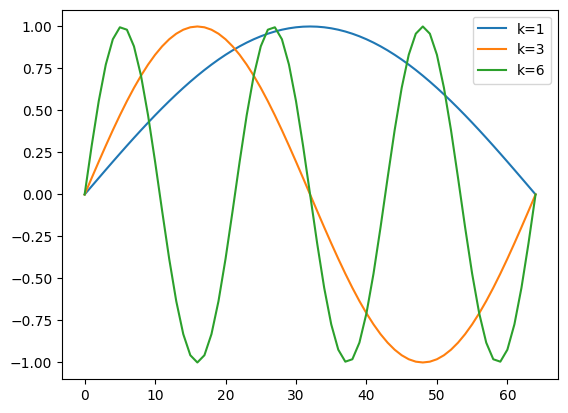

In [68]:
import matplotlib.pyplot as plt
import numpy as np

N = 64
v = np.zeros((N+1,N+1),dtype=np.float64)

for i in range(1,N):
    for k in range(1,N):
        v[i,k] = np.sin(i*k*np.pi/N)
v1 = v[:,1]
v3 = v[:,2]
v6 = v[:,6]

plt.plot(v1, label="k=1")
plt.plot(v3, label="k=3")
plt.plot(v6, label="k=6")
plt.legend()

可见k=1,3,6频率越来越高。

然后我们利用weighted Jacobi迭代法进行迭代, 其中omega=2/3

它的迭代公式为：
$$
v_i^{(new)}=(1-\omega)v_{i}^{(old)} + (\omega/ 2) \left(v_{i-1}^{(old)}+v_{i+1}^{(old)} +h^2 f_i \right)
$$


我们设定初始值为
$$
v_0=\frac{1}{3}\left(\sin \left(\frac{j \pi}{N}\right)+\sin \left(\frac{6 j \pi}{N}\right)+\sin \left(\frac{32 j \pi}{N}\right)\right)
$$


在我们的例子中，omega=2/3, f=0, h=1/N



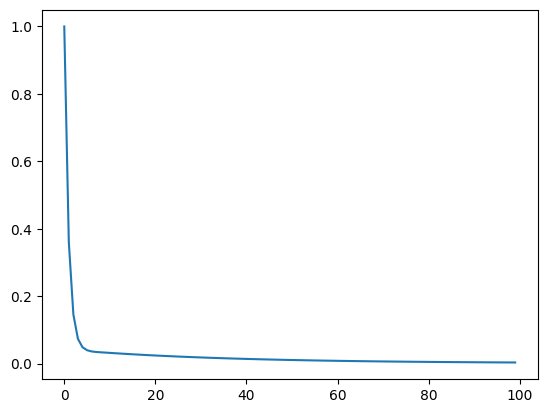

In [69]:
# 首先我们绘制v的误差下降曲线
v0 = np.zeros((N+1),dtype=np.float64)
for j in range(1,N):
    v0[j] = 1/3 * (np.sin(j*np.pi/N) + np.sin(6*j*np.pi/N) + np.sin(32*j*np.pi/N))
v_new = np.zeros((N+1),dtype=np.float64)
v_old = np.zeros((N+1),dtype=np.float64)
num_iters = 100
v_old = v0
error = []
for i in range(num_iters):
    v_new[1:N] = 1./3 * v_old[1:N] + 1./3 * (v_old[2:N+1] + v_old[0:N-1])
    error.append(np.linalg.norm((v_new[1:N] - v_old[1:N]),np.inf) )
    v_old[:] = v_new[:]
plt.plot(error/error[0])

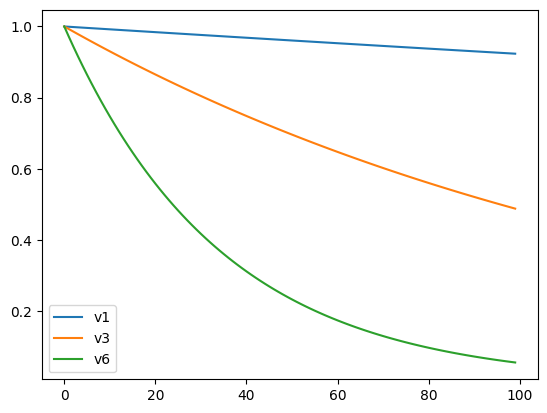

In [70]:
# 然后我们分别绘制v1,v3,v6的误差下降曲线
# 迭代公式完全一样，只有初始值不一样

def weighted_jacobian(v0, label):
    v_new = np.zeros((N+1),dtype=np.float64)
    v_old = np.zeros((N+1),dtype=np.float64)
    num_iters = 100
    v_old = v0
    error = []
    for i in range(num_iters):
        v_new[1:N] = 1./3 * v_old[1:N] + 1./3 * (v_old[2:N+1] + v_old[0:N-1])
        error.append(np.linalg.norm((v_new[1:N] - v_old[1:N]),np.inf) )
        v_old[:] = v_new[:]
    plt.plot(error/error[0], label=label)

# v1
v01 = np.zeros((N+1),dtype=np.float64)
for j in range(1,N):
    v01[j] = 1/3 * (np.sin(j*np.pi/N))
weighted_jacobian(v01,'v1')

# v3
v03 = np.zeros((N+1),dtype=np.float64)
for j in range(1,N):
    v03[j] = 1/3 * (np.sin(3*j*np.pi/N))
weighted_jacobian(v03,'v3')

# v6
v06 = np.zeros((N+1),dtype=np.float64)
for j in range(1,N):
    v06[j] = 1/3 * (np.sin(6*j*np.pi/N))
weighted_jacobian(v06,'v6')

plt.legend()

可见，v1的收敛速度最慢，v3的收敛速度次之，v6的收敛速度最快。
所以，频率越高，收敛速度越快。
完毕。

## 接下来我们从矩阵视角考量收敛性

将A分解为A=D-L-U，得到矩阵形式的迭代公式为
$$
\begin{aligned}
v^{(\text {new })}= & {\left[(1-\omega) I+\omega D^{-1}(L+U)\right] v^{(\text {old })}+\omega h^2 D^{-1} f } \\
& =R_\omega v^{(\text {old })}+\omega h^2 D^{-1} f
\end{aligned}
$$

其中
$$
R_\omega=\left[(1-\omega) I+\omega D^{-1}(L+U)\right]
$$

因为$e^{new}=u^{new}-v^{new}=R(u^{old}-v^{old})=Re^{old}$，所以
$$
e^{(new)}=R_\omega e^{(old)}
$$


我们写出来A是什么
$$
\begin{gathered}
i=1 &\quad-u_0+2 u_1-u_2=0 \\
i=2 &\quad-u_1+2 u_2-u_3=0 \\
\vdots\\
i=N-1 &\quad -u_{N-2}+2 u_{N-1}-u_N=0
\end{gathered}
$$
(注意到$u_0=u_N=0$)

$$
A=\begin{bmatrix}
 2&  -1&  &      \\
 -1 &  2&  -1&     \\
 &&   \vdots \\
 &  &  &  &  -1&  2  \\
\end{bmatrix} 
$$

A=D-L-U 其中D就是对角线，L是下三角，U是上三角。我们可以写出来
$$
D=\begin{bmatrix}
 2&  &  &        \\
 &   2 &  &       \\
 &    &      \ddots \\
 &  &    &  2 \\
\end{bmatrix}
$$

$$
L=\begin{bmatrix}
 0&  &  &  &  &    \\
 -1&   0 &  &  &  &   \\
 &    -1&    0&   &  &   \\
 &    &    &   \ddots \\
&  &  &    -1&  0 \\
\end{bmatrix}
$$

$$
U=\begin{bmatrix}
 0&  -1&  &  &  \\
 &   0 &  -1&  & \\
 &    &   \ddots\\
 &  &  &    0\\
\end{bmatrix}

In [84]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

D = np.diag(np.ones(N-1,dtype=np.float64) * 2)
L = np.diag(np.ones(N-2,dtype=np.float64) ,1)
U = np.diag(np.ones(N-2,dtype=np.float64) ,-1)
A = D - L - U
I = np.eye(N-1)
R = 1./3 * I + 1./3 * np.linalg.inv(D) @ (L + U)
A

array([[ 2., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  2., -1., ...,  0.,  0.,  0.],
       [ 0., -1.,  2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  2., -1.,  0.],
       [ 0.,  0.,  0., ..., -1.,  2., -1.],
       [ 0.,  0.,  0., ...,  0., -1.,  2.]])

我们首先从eigen values和 eigen vectors的意义上考虑问题。
“eigen”这个词根是德语的词源，表示own。意思是最本质，最能代表自身的东西。
**任意一个矩阵A，它的eigen vectors就是它的一组基。**

可以通过线性组合A的eigen vectors(记为w_k)来表示任意在A的列空间内的向量。
即
$$
\boldsymbol{v}=\sum_{k=1}^N c_k w_k
$$

其中$c_k$是组合系数


由于Au=0的解一定在A的列空间内。
那么e=u-v 一定也在其列空间内，其中u是其真解，v是其近似解。
所以e也可以用w_k来表示。

我们先写出initial error

$$
\boldsymbol{e^0}=\sum_{k=1}^{N-1} c_k w_k
$$

然后再写出M次迭代之后的error

$$
\boldsymbol{e^M}=\sum_{k=1}^{N-1} c_k R^M w_k = \sum_{k=1}^{N-1} c_k \lambda_k^M w_k
$$

其中能用lambda替换R的原因是eigen vectors 和 eigen values有如下的等式关系：
$$
A w_k = \lambda_k w_k
$$

由于R仅仅是A的各个部分的线性组合（如下），
$$
R = (1-\omega)I + \omega D^{-1}(L+U)
 = I - \omega D^{-1} A
$$
所以R的特征向量与A的特征向量相同，特征值有简单的线性关系（如下）。

$$
\lambda(R) = 1 - \frac{\omega}{2} \lambda(A)
$$

这里出现的1/2是因为D的对角项元素是2.

接着，我们来绘制一下不同k对应的eigen vectors的图像。

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

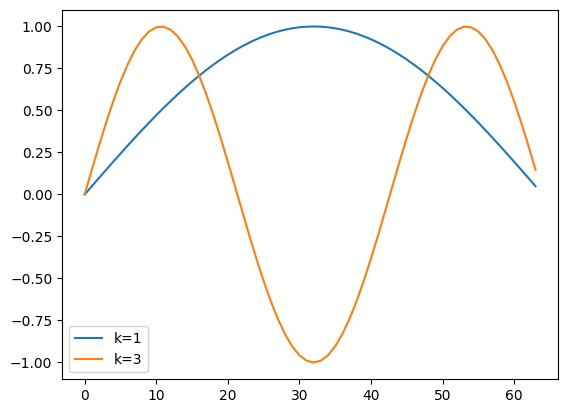

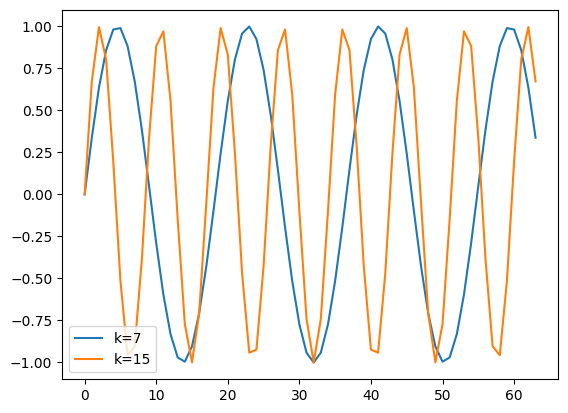

In [79]:
# 绘制Eigen Vector
w = np.zeros((N,N),dtype=np.float64)
def draw_eigen_vector(k):
    # plt.figure()
    for j in range(1,N):
        w[k,j] = np.sin(j*k*np.pi/N)
    plt.plot(w[k,:], label="k={}".format(k))
    plt.legend()

for i in [1,3,7,15]:
    if i == 1 or i== 7:
        plt.figure()
    draw_eigen_vector(i)

观察这张图，这张图代表了不同k值下不同eigen vectors的图像。
我们来思考k的含义：
每个eigen vector代表了傅里叶分析的模态。
k则代表了信号的波数。
k小，代表低频；k大，代表高频。

我们大致以中点N/2作为高频与低频的分界，认为k<N/2的是低频，k>N/2的是高频。

然后我们来绘制eigen values的图像。

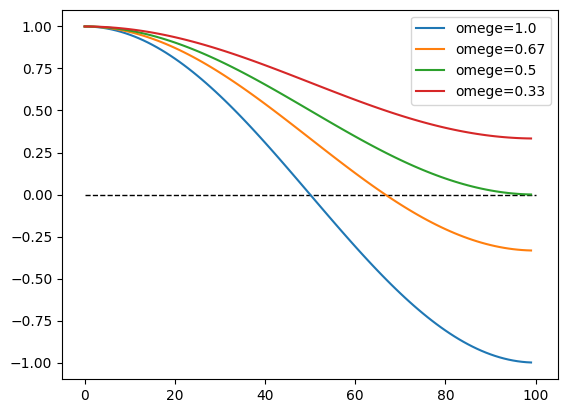

In [85]:
# 绘制eigenvalue(不同omega)
from numpy import pi, sin, cos, exp
from matplotlib.pyplot import plot

def plot_eigenvalue(omege):
    N = 100
    lam = np.zeros((N),dtype=np.float64)
    for k in range(N):
        lam[k] = 1 - 2*omege*sin(k*pi/N/2)**2
    plot(lam, label="omege={:.2}".format(omege))
plot([0,100],[0,0], color='black', linestyle='--', linewidth=1)
plot_eigenvalue(1.)
plot_eigenvalue(2./3)
plot_eigenvalue(1./2)
plot_eigenvalue(1./3)
plt.legend()

我们考察不同omega下eigen values的曲线图，这张图的横坐标是k，纵坐标是eigen values。

我们发现当0<=omega<=1的时候，eigen values是处于-1到1之间的。
这是因为
$$
\lambda(R) = 1 - 2 \omega sin^2(\frac{k\pi}{2N})
$$
当0<=omega<=1的时候显然是处于-1到1之间的。

从eigen values这张图中我们还可以推出其他结论

对于eigen values这张图来说，横坐标是k，表示不同频率的模态，纵坐标是eigen values，表示不同模态的衰减率。
为什么eigen values能代表衰减率呢？这是因为对迭代法来说**矩阵R的谱半径$\rho(R)$代表其收敛因子**（convergence factor）。谱半径越小，收敛越快。即eigen values的绝对值越小，收敛越快。

实际上，有个smoothing factor的定义也是这么来的：

$$
\text{smoothing factor} = max|\lambda_k(R)| \\
for \quad N/2<=k<=N
$$

实际上，我们可以绘制出收敛性随波数k的变化
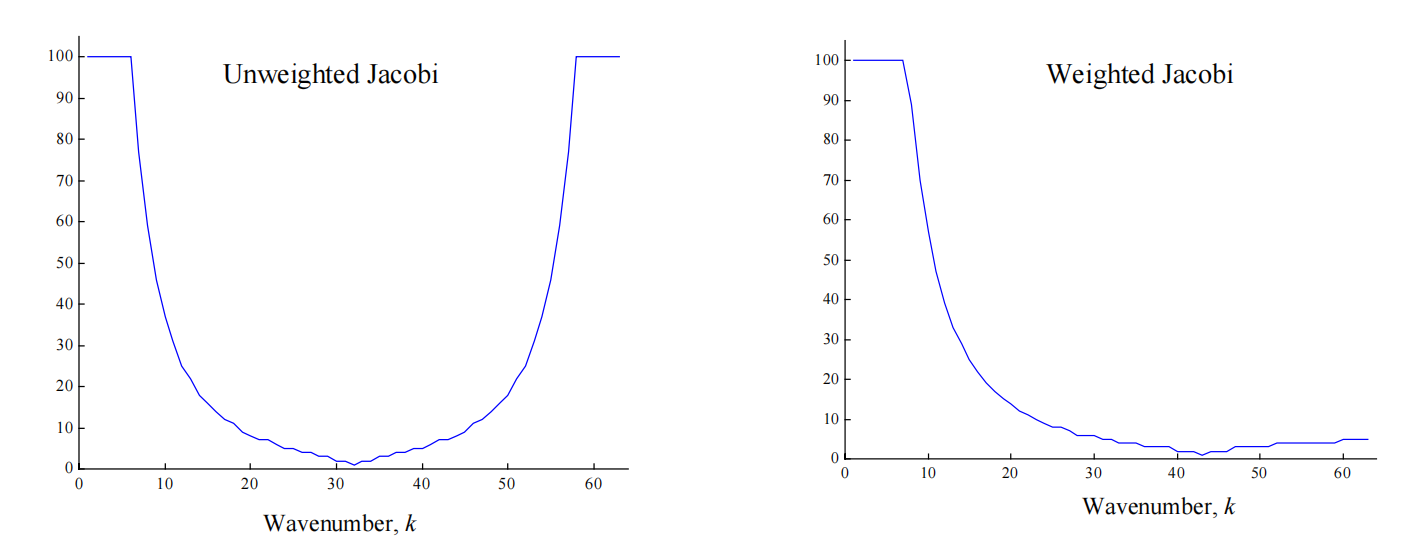

这张图的横坐标是波数k，纵坐标是收敛到$||e||_\infty=0.1$所需要的iter数。

initial guess为
$$
v_{kj} = sin(\frac{jk\pi}{N})
$$

实际上，我们从下面的实验也可以看出。迭代法经过35次iter之后，只能消除oscillatory error，而不能消除smooth error。

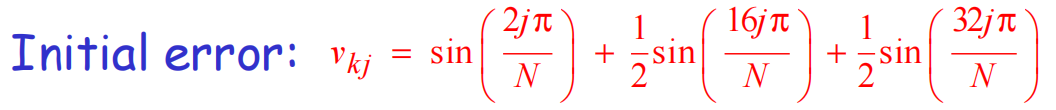

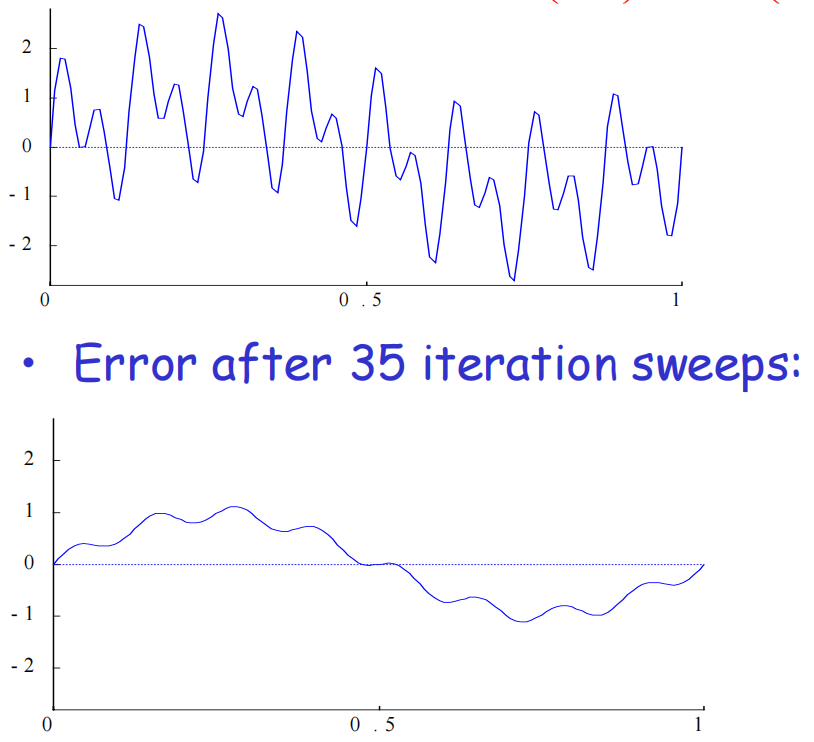

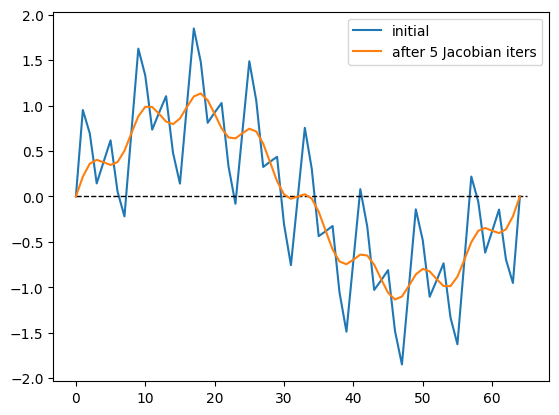

In [104]:
#经过5 iter之后的v
def weighted_jacobian(v0):
    v_new = np.zeros((N+1),dtype=np.float64)
    v_old = np.zeros((N+1),dtype=np.float64)
    num_iters = 5
    v_old = v0
    error = []
    for i in range(num_iters):
        v_new[1:N] = 1./3 * v_old[1:N] + 1./3 * (v_old[2:N+1] + v_old[0:N-1])
        v_old[:] = v_new[:]
    return v_new


v0 = np.zeros((N+1),dtype=np.float64)
for j in range(1,N):
    v0[j] =  (np.sin(2*j*pi/N)) + 1./2 * (np.sin(16*j*pi/N)) + 1./2 * (np.sin(32*j*pi/N))
plot(v0, label='initial')
plot([0,65],[0,0], color='black', linestyle='--', linewidth=1)
v_new = weighted_jacobian(v0)
plot(v_new, label='after 5 Jacobian iters')

plt.legend()

即使改为Gauss-Seidel迭代，我们也能得到相同的结论

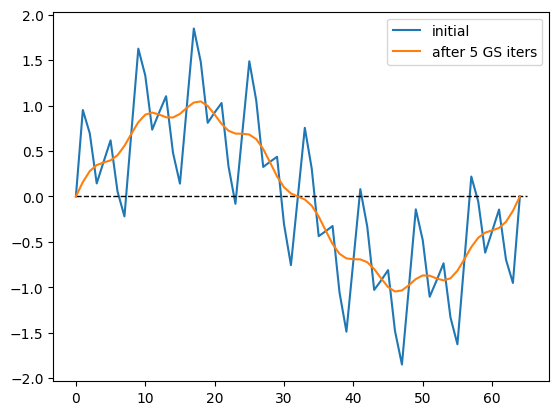

In [105]:
#改为gauss-seidel
def gauss_seidel(v0):
    v_new = np.zeros((N+1),dtype=np.float64)
    v_old = np.zeros((N+1),dtype=np.float64)
    num_iters = 5
    v_old = v0
    error = []
    for i in range(num_iters):
        v_new[1:N] = 1./2 * (v_old[0:N-1] + v_old[2:N+1])
        v_old[:] = v_new[:]
    return v_new


v0 = np.zeros((N+1),dtype=np.float64)
for j in range(1,N):
    v0[j] =  (np.sin(2*j*pi/N)) + 1./2 * (np.sin(16*j*pi/N)) + 1./2 * (np.sin(32*j*pi/N))
plot(v0, label='initial')
plot([0,65],[0,0], color='black', linestyle='--', linewidth=1)
v_new = gauss_seidel(v0)
plot(v_new, label='after 5 GS iters')

plt.legend()

我们也可以绘制一下GS法的eigen values和eigen vectors

Eigen values
$$
\lambda(R) = cos^2(\frac{k\pi}{N})
$$

Eigen vectors
$$
w_{kj} = (\lambda_k)^{j/2} sin(\frac{jk\pi}{N})
$$

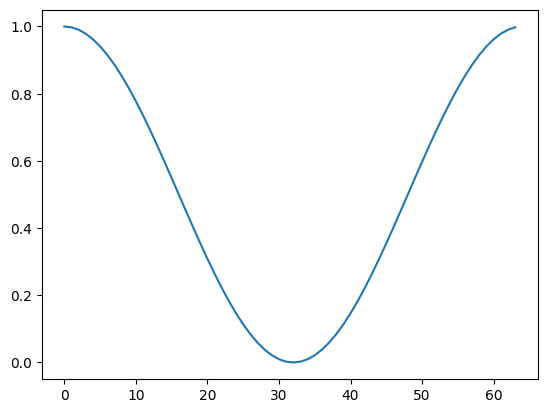

In [108]:
## 绘制lambda
def plot_eigenvalue():
    lam = np.zeros((N),dtype=np.float64)
    for k in range(N):
        lam[k] = cos(k*pi/N)**2
    plot(lam, label="lambda")
plot_eigenvalue()

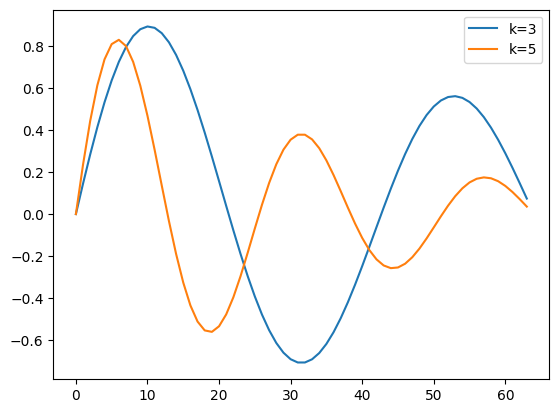

In [112]:
## 绘制 eigen vector
def plot_eigenvector(k):
    lam = np.zeros((N),dtype=np.float64)
    w = np.zeros((N,N),dtype=np.float64)
    
    lam[k] = cos(k*pi/N)**2
    for j in range(N):
        w[k,j] = lam[k]**(j/2) * sin(j*k*pi/N)
    plot(w[k,:], label="k={}".format(k))

plot_eigenvector(3)
plot_eigenvector(5)
plt.legend()